In [1]:
#download and unzip all files from kaggle - requires integration with kaggle
#uncomment to run

# !kaggle competitions download -c walmart-recruiting-store-sales-forecasting -p data
# !unzip data/walmart-recruiting-store-sales-forecasting.zip -d data/tmp
# !rm -r data/store-sales
# !unzip data/tmp/features.csv.zip -d data/store-sales
# !unzip data/tmp/sampleSubmission.csv.zip -d data/store-sales
# !unzip data/tmp/train.csv.zip -d data/store-sales
# !unzip data/tmp/test.csv.zip -d data/store-sales
# !cp data/tmp/stores.csv data/store-sales/stores.csv
# !rm -r data/tmp

In [2]:
import pandas as pd

In [3]:
features = pd.read_csv("data/store-sales/features.csv")
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [4]:
stores = pd.read_csv("data/store-sales/stores.csv")
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [5]:
data = pd.read_csv("data/store-sales/train.csv")
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [6]:
from prophet import Prophet

/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [7]:
# example for store 1 and dept 1
train_data = data[(data["Store"] == 1) & (data["Dept"] == 1)][["Date", "Weekly_Sales"]]
train_data.columns = ["ds", "y"]
train_data

,ds,y
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90
...,...,...
138,2012-09-28,18947.81
139,2012-10-05,21904.47
140,2012-10-12,22764.01
141,2012-10-19,24185.27


In [8]:
m = Prophet()
m.fit(train_data)

13:03:21 - cmdstanpy - INFO - Chain [1] start processing
13:03:21 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
future = m.make_future_dataframe(periods=365)
future

,ds
0,2010-02-05
1,2010-02-12
2,2010-02-19
3,2010-02-26
4,2010-03-05
...,...
503,2013-10-22
504,2013-10-23
505,2013-10-24
506,2013-10-25


In [10]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
503,2013-10-22,29404.575615,22238.284395,36652.132644
504,2013-10-23,30213.999231,22758.025480,37751.469443
505,2013-10-24,30977.771584,22932.212134,37911.664785
506,2013-10-25,31679.424597,24479.995490,38762.154862
507,2013-10-26,32302.983758,25216.204339,39072.524036


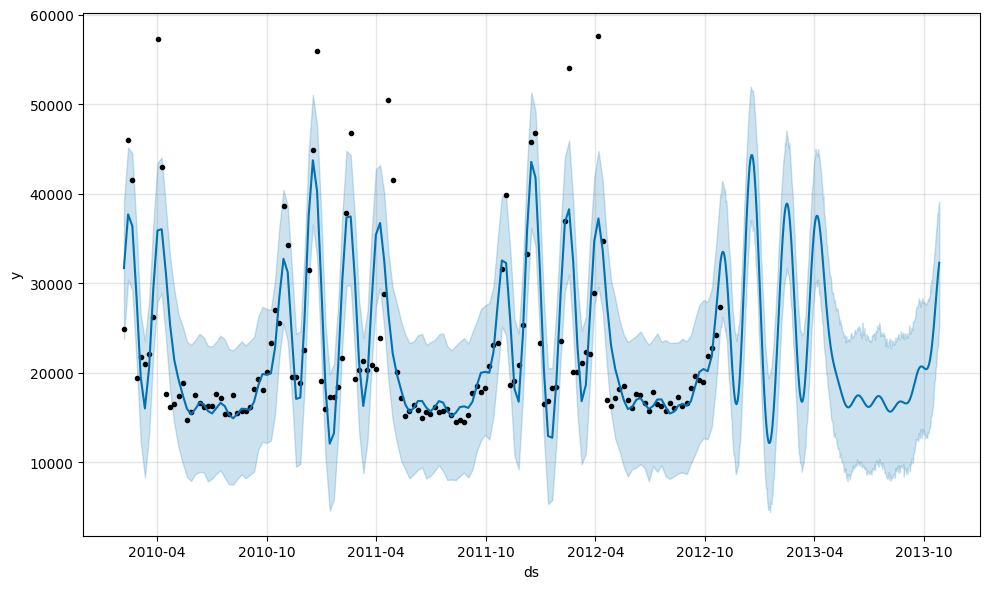

In [11]:
fig1 = m.plot(forecast)